In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.manifold import TSNE
#from visualization import visualize, display, sequence_identity
from rdkit.Chem import AllChem
from scipy.stats import spearmanr, ttest_ind

import matplotlib as mpl
font = {'size' : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

#to the column labeled as ['0']
def find_column(df, label):
    """
    finds the column index of a given label
    """
    for i, col in enumerate(df.columns):
        if col == label:
            return i
    return None

def get_average_accuracy(accuracy_level_list, level):
    """
    returns the average accuracy at a given level
    """
    return np.mean([1 if x >= level else 0 for x in accuracy_level_list])

def expand_list(predicted_ECs):
    """
    for every entry in predicted_ECs, split by ';' and expand the list
    """
    expanded = []
    for entry in predicted_ECs:
        # if entry is a list
        if type(entry) == list:
            print('ERROR: ')
            print(entry)
            return entry
        else:
            expanded.extend(entry.split(';'))
    return expanded

def get_accuracy_level(predicted_ECs, true_ECs):
    """
    based on a list of predicted_ECs, calculates the highest level of accuracy achieved, against all true_ECs. Returns a list of the same length as true_ECs.
    """
    #convert true_EC to a list
    if type(predicted_ECs) == str:
        predicted_ECs = [predicted_ECs]
        
    if type(true_ECs) == str:
        true_ECs = [true_ECs]

    maxes = []
    for true_EC in true_ECs:

        true_split = true_EC.split('.')
        
        counters = []
        for predicted_EC in predicted_ECs:
            try:
                predicted_split = predicted_EC.split('.')
                counter = 0
    
                for predicted, true in zip(predicted_split, true_split):
                    if predicted == true:
                        counter += 1
                    else:
                        break
                counters.append(counter)
                #print(counters)
            except:
                print("ERROR:", predicted_EC)
        
        maxes.append(np.max(counters))
    return maxes
#import umap

def get_results(task):
    results = pd.DataFrame(columns=['baseline', 'split', 'k', 'level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy'])

    #load the query_df that's already been generated

    if task == 'task1':
        #baselines = ['random', 'BLAST', 'ChatGPT', 'ProteInfer',  'CLEAN']
        baselines = ['random', 'BLAST', 'CLEAN']
        splits = ['30', '30-50', 'price', 'promiscuous']
        modality = 'protein'
    else:
        #baselines = ['random', 'Similarity', 'ChatGPT_reaction', 'ChatGPT', 'CLIPZyme', 'CREEP', 'CREEP_text']
        baselines = ['random', 'Similarity', 'CLIPZyme', 'CREEP', 'CREEP_text']
        splits = ['easy', 'medium', 'hard']
        modality = 'reaction'

    for baseline in baselines:
        for split in splits:

            query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality)) #take a different baseline and randomize it
            # if task == 'task1':
            #         num_cols = 3
            # else:
            #     num_cols = len(query_df.columns) - num_ECs
            num_cols = find_column(query_df, '0')
            
            #fill na for columns after num_cols with '0.0.0.0'
            query_df.iloc[:, num_cols:] = query_df.iloc[:, num_cols:].fillna('0.0.0.0')

            # query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality))
            # num_cols = sum(isinstance(name, str) for name in query_df.columns)
            # print(num_cols)
            #query_df = query_df.iloc[141:142,:]


            #make a k=1 retrieval accuracy table, broken down by accuracy greater than or equal to level 1, 2, 3, 4

            #change this line if you have fewer rankings available
            #for k in [1, 5]:
            for k in [1, 3, 5, 10, 20, 30, 40, 50]:
                #collapse columns 0:3 into a single column list
                #print(baseline)
                query_df['predicted ECs'] = query_df.iloc[:, num_cols:num_cols+k].values.tolist()
                #for each entry in the list, split out entries that contain ';'
                if baseline == 'BLAST':
                    query_df['predicted ECs'] = query_df['predicted ECs'].apply(lambda x: expand_list(x))
                    query_df['EC number']

                query_df['EC number list'] = query_df['EC number'].apply(lambda x: x.split(';'))
                
                query_df['k={} accuracy level'.format(k)] = query_df.apply(lambda x: get_accuracy_level(x['predicted ECs'],  x['EC number list']), axis=1)

                accuracies = []
                for i in [4, 3, 2, 1]:
                    query_df['accuracy'] = query_df['k={} accuracy level'.format(k)].apply(lambda x: get_average_accuracy(x, i))
                    accuracy = query_df['accuracy'].mean()

                    #old way of doing it (enzymes with more labels are weighted more heavily)
                    # exploded = query_df.explode('k={} accuracy level'.format(k))
                    # accuracy = exploded[exploded['k={} accuracy level'.format(k)] >= i].shape[0] / exploded.shape[0]
                    
                    accuracies.append(round(accuracy*100, 1))
                    
                results.loc[len(results)] = [baseline, split, k, accuracies[0], accuracies[1], accuracies[2], accuracies[3]]
    
    return results

#supress warnings
import warnings
warnings.filterwarnings("ignore")

### Before running, results must be processed into the correct format as csvs under `results_summary`

### Get accuracy metrics for Task 1

In [8]:
results = get_results('task1')

ERROR: 
['1.1.1.35', ' 4.2.1.17', ' 5.3.3.8']
ERROR: 
['1.1.1.320']
ERROR: 
['1.1.1.30']
ERROR: 
['0.0.0.0']
ERROR: 
['1.1.3.37']
ERROR: 
['1.1.3.8']
ERROR: 
['1.5.3.6']
ERROR: 
['0.0.0.0']
ERROR: 
['1.1.5.4']
ERROR: 
['1.1.99.2']
ERROR: 
['1.1.5.14']
ERROR: 
['1.1.99.14']
ERROR: 
['1.10.3.3']
ERROR: 
['1.10.3.11']
ERROR: 
['1.10.3.2', ' 1.3.3.5']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['1.12.98.1']
ERROR: 
['7.1.1.2']
ERROR: 
['7.1.1.2']
ERROR: 
['0.0.0.0']
ERROR: 
['1.12.99.6']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['1.14.11.27']
ERROR: 
['1.14.11.2']
ERROR: 
['1.14.11.27']
ERROR: 
['1.14.19.21']
ERROR: 
['0.0.0.0']
ERROR: 
['1.14.13.9']
ERROR: 
['1.14.13.20']
ERROR: 
['1.14.13.122']
ERROR: 
['1.14.14.137']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['1.14.16.1']
ERROR: 
['1.14.11.61']
ERROR: 
['0.0.0.0']
ERROR: 
['0.0.0.0']
ERROR: 
['1.14.18.1']
ERROR: 
['1.14.

In [9]:
results['baseline'] = pd.Categorical(results['baseline'], ['random', 'BLAST', 'ChatGPT', 'ProteInfer', 'CLEAN'])
results
results[results['k'] == 1].sort_values(by=['split', 'baseline'])[results['split'] != 'promiscuous']

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,random,30,1,0.0,1.2,3.2,19.4
32,BLAST,30,1,49.8,59.5,62.0,65.3
64,CLEAN,30,1,55.1,68.8,74.8,84.5
8,random,30-50,1,0.0,0.7,3.6,22.5
40,BLAST,30-50,1,79.3,86.2,89.5,91.6
72,CLEAN,30-50,1,80.2,88.0,91.6,95.5
16,random,price,1,0.0,0.7,4.7,22.3
48,BLAST,price,1,32.4,70.9,78.4,78.4
80,CLEAN,price,1,31.8,74.3,81.8,85.8


In [10]:
results[results['k'] == 5][results['split'] == 'promiscuous']

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
26,random,promiscuous,5,0.5,7.0,18.6,65.0
58,BLAST,promiscuous,5,43.3,48.7,57.0,66.8
90,CLEAN,promiscuous,5,77.9,86.1,88.5,93.3


### Get accuracy metrics for Task 2

In [11]:
results = get_results('task2')

In [12]:
results['baseline'] = pd.Categorical(results['baseline'], ['random', 'Similarity', 'ChatGPT_reaction', 'ChatGPT', 'CLIPZyme', 'CREEP', 'CREEP_text'])
results['split'] = pd.Categorical(results['split'], ['easy', 'medium', 'hard'])
#results
results[results['k'] == 1].sort_values(by=['split', 'baseline'])

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,random,easy,1,0.0,1.0,4.6,22.9
24,Similarity,easy,1,59.3,77.1,85.2,90.6
48,CLIPZyme,easy,1,12.2,39.9,61.8,79.9
72,CREEP,easy,1,39.4,66.4,79.9,92.9
96,CREEP_text,easy,1,60.3,89.3,93.9,96.7
8,random,medium,1,0.0,0.5,4.1,17.0
32,Similarity,medium,1,0.0,40.2,55.7,73.3
56,CLIPZyme,medium,1,2.0,26.0,46.6,69.0
80,CREEP,medium,1,4.1,44.3,63.1,86.5
104,CREEP_text,medium,1,7.4,59.5,75.6,92.1


Lineplots showing increase in accuracy over time

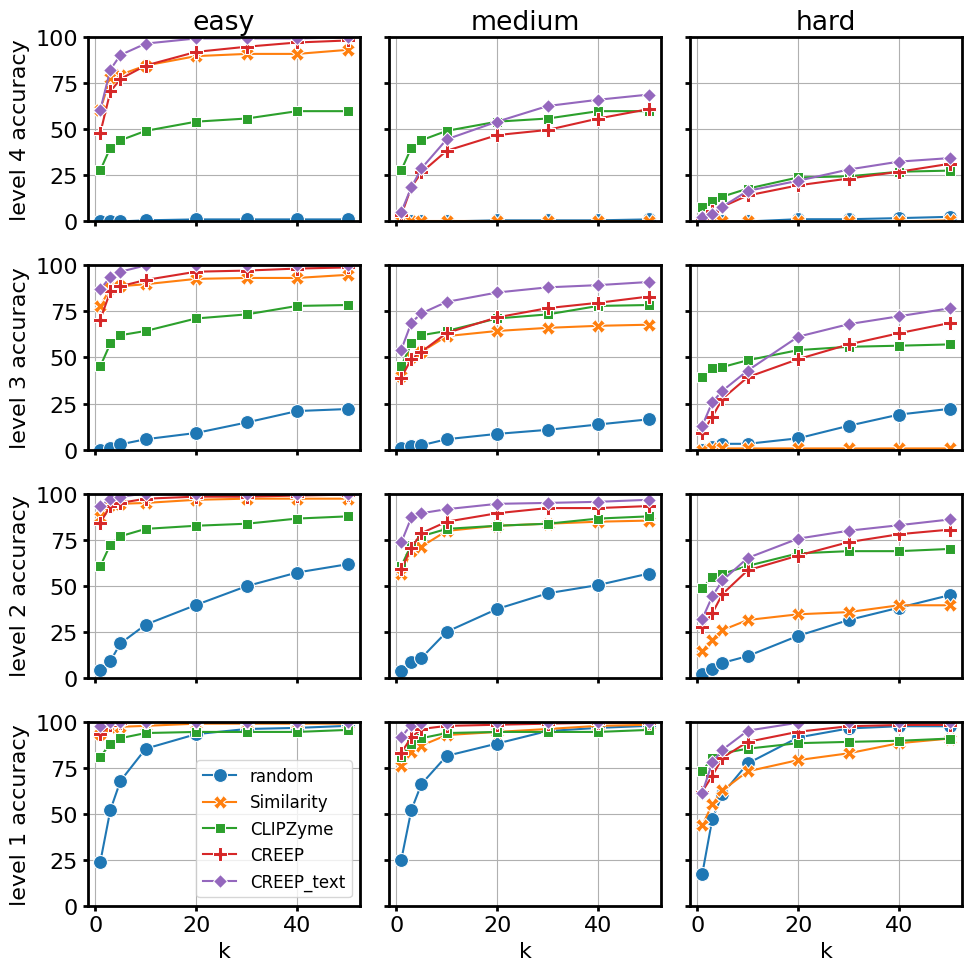

In [70]:
splits = ['easy', 'medium', 'hard']
results['baseline'] = results['baseline'].astype(str)

plt.figure(figsize=(10, 10))
i = 0
for metric in ['level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy']:
    for split in splits:
        i += 1
        plt.subplot(4, 3, i)
        subset = results[results['split'] == split][~results['baseline'].isin(['ChatGPT', 'ChatGPT_reaction'])]
        
        if i == 10:
            sns.lineplot(data=subset, x="k", y=metric, hue="baseline", markers=True, style="baseline", dashes=False, markersize=10, legend=True)
            plt.legend(fontsize=12, title='')
        else:
            sns.lineplot(data=subset, x="k", y=metric, hue="baseline", markers=True, style="baseline", dashes=False, markersize=10, legend=False)
            
            #change legend font size

        if i <= 3:
            plt.title(split)
        #remove the ylabel and y axis tick labels for all but the left subplots
        if i % 3 != 1:
            plt.ylabel('')
            ax = plt.gca()
            ax.set_yticklabels('')
            #plt.set_xticklabels(None)
        #remove the xlabel and x axis ticks for all but the bottom subplots
        if i < 10:
            plt.xlabel('')
            ax = plt.gca()
            ax.set_xticklabels('')

        plt.grid(True)
        plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('generate_datasets_splits/figs/lineplots.png', dpi=500)

In [3]:
#don't use this anymore ariane put it elsewhere
#generate and save random EC rankings for each task and all splits
# for task in ['task1']:
#     if task == 'task1':
#         baselines = task1_baselines
#         splits = task1_splits
#         modality = 'protein'
#     else:
#         baselines = task2_baselines
#         splits = task2_splits
#         modality = 'reaction'

#     for split in splits:
#         query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'CLEAN', split, modality))

#         num_cols = find_column(query_df, '0')
#         print(num_cols)

#         for i in range(query_df.shape[0]):
#             np.random.seed(42)
#             #shuffle the columns
#             query_df.iloc[i, num_cols:] = query_df.iloc[i, num_cols:].sample(frac=1).values
        
#         query_df.to_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'Random', split, modality), index=False)

3
3
3
3


### Measure similarity to reactions in the train set

In [2]:
results = pd.DataFrame()
for split in ['easy', 'medium', 'hard']:
    reaction_similarities = np.load('task2_baselines/Similarity/output/{}_split/retrieval_results/{}_reaction_test_reaction2reaction_retrieval_similarities.npy'.format(split, split))
    query_df = pd.read_csv('task2_baselines/results_summary/CREEP/{}_reaction_test_results_df.csv'.format(split))
    reference_df = pd.read_csv('splits/task2/{}_reaction_train.csv'.format(split))

    query_df['Correct'] = query_df['EC number'] == query_df['0']
    #apply get accuracy level
    query_df['k=1 accuracy level'] = query_df.apply(lambda x: get_accuracy_level(x['0'], x['EC number'])[0], axis=1)
    query_df['Similarity'] = np.max(reaction_similarities, axis=1)
    query_df = query_df.sort_values(by='Similarity', ascending=False)
    query_df['Split'] = split
    results = pd.concat([results, query_df], axis=0)
results

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,members EC,Reactions with a single EC,...,4954,4955,4956,4957,4958,4959,Correct,k=1 accuracy level,Similarity,Split
183,N=c1[nH]c(=O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(...,[NH:1]=[c:2]1[nH:3][c:4](=[O:5])[c:6]2[n:7][cH...,2.7.4.22,GTP + UMP = GDP + UDP {r},2.7.4,2.70,2,True,9,1,...,3.2.1.199,1.14.15.26,3.2.1.2,2.4.1.7,4.2.1.6,3.2.1.176,False,2,1.0,easy
181,Nc1nc2c(ncn2[C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[NH2:1][c:2]1[n:3][c:4]2[c:5]([n:6][cH:7][n:8]...,2.7.4.22,GTP + UMP = GDP + UDP {r},2.7.4,2.70,2,True,9,1,...,4.2.1.68,4.2.1.146,1.14.15.29,7.1.1.7,4.2.1.6,3.2.1.176,False,2,1.0,easy
182,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,2.7.4.22,ATP + 6-aza-UMP = ADP + 6-aza-UDP,2.7.4,2.70,2,True,9,1,...,1.14.15.8,1.14.15.15,4.2.1.6,1.14.15.14,1.14.15.28,1.14.15.29,False,3,1.0,easy
385,N.N[C@@H](CC(=O)O)C(=O)O.Nc1ncnc2c1ncn2[C@H]1C...,[NH2:11][c:12]1[n:13][cH:14][n:15][c:16]2[c:17...,6.3.5.4,dATP + L-Asp + NH3 = dAMP + diphosphate + Asn,6.3.5,6.30,6,True,11,1,...,2.4.1.384,4.1.1.7,2.3.1.20,2.3.1.162,2.4.1.335,2.3.1.166,False,0,1.0,easy
367,CNc1ccccc1C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...,[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][cH:7][c:...,5.6.2.4,2'(3')-O-(N-methylanthraniloyl)ATP + H2O = 2'(...,5.6.2,5.60,5,True,11,1,...,1.1.1.326,4.1.2.46,1.1.1.16,1.8.1.5,4.1.1.121,1.1.1.295,False,0,1.0,easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,N[C@@H](CO)C(=O)O.O=C(O)C(=O)CO>>N[C@@H](CO)C(...,[NH2:1][C@@H:2]([CH2:3][OH:4])[C:5](=[O:6])[OH...,2.6.1.45,L-serine + 3-hydroxypyruvate = 3-hydroxypyruva...,2.6.1,2.60,2,True,16,1,...,1.14.19.5,2.3.1.20,1.14.14.1,1.14.14.80,2.3.1.225,1.14.14.129,False,0,0.0,hard
377,CC[C@H](C)[C@H](NC(=O)[C@H](C)N)C(=O)N1CCC[C@H...,[CH3:1][CH2:2][C@H:3]([CH3:4])[C@H:5]([NH:6][C...,5.2.1.8,Ala-Ile-(cis)-Pro-Phe = Ala-Ile-(trans)-Pro-Phe,5.2.1,5.20,5,True,60,1,...,1.18.1.6,4.2.1.66,4.1.1.98,4.2.1.2,1.4.1.13,4.1.1.61,False,1,0.0,hard
107,N=C(S)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:45][C:46](=[O:47])[C:48]1=[CH:49][N:50]([...,1.8.1.8,thio-NAD+ + NAD(P)H = NAD+ + thio-NAD(P)H,1.8.1,1.80,1,True,13,1,...,6.3.3.5,3.4.21.12,4.2.3.98,3.4.14.13,4.2.3.124,6.3.3.7,False,1,0.0,hard
357,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,8,1,...,1.14.11.47,2.4.1.70,2.4.1.225,2.4.1.224,1.14.14.11,2.4.1.255,False,1,0.0,hard


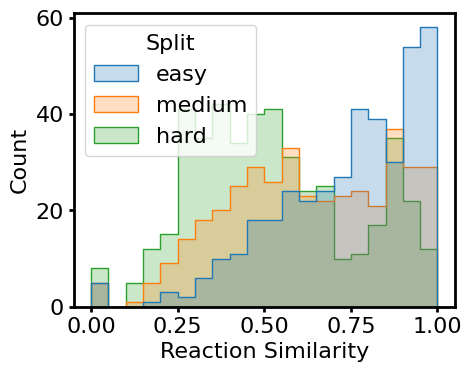

In [3]:
plt.figure(figsize=(5, 4))
sns.histplot(results, x='Similarity', hue='Split', element="step",stat="count", bins=20, fill=True)
sns.move_legend(plt.gca(), "upper left")
plt.xlabel('Reaction Similarity')
plt.tight_layout()
plt.savefig('generate_datasets_splits/figs/task2_similarity_histogram.png', dpi=500)

### Visualize if predictions on the more similar reactions are more accurate

Ttest_indResult(statistic=5.104055220328118, pvalue=4.6850408074296735e-07)


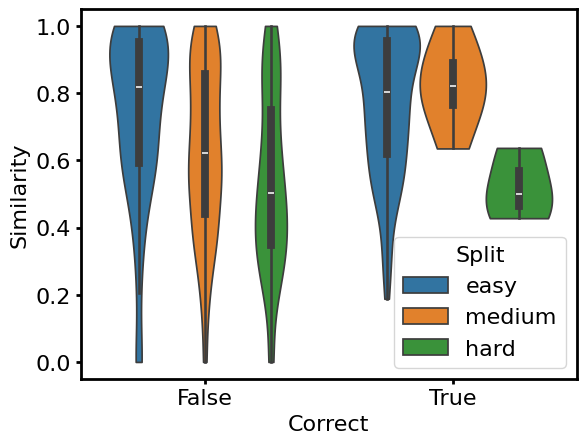

In [17]:
#calculate the correlation between correct and reaction similarity
#print(spearmanr(merged['reaction_similarity'],merged['correct']))
#subset = results[results['Split'] == 'hard']
print(ttest_ind(results[results['Correct']]['Similarity'], results[~results['Correct']]['Similarity']))
sns.violinplot(data=results, x='Correct', y='Similarity', hue='Split', cut=False)

SpearmanrResult(correlation=0.2997393476798378, pvalue=3.4144401043179985e-12)


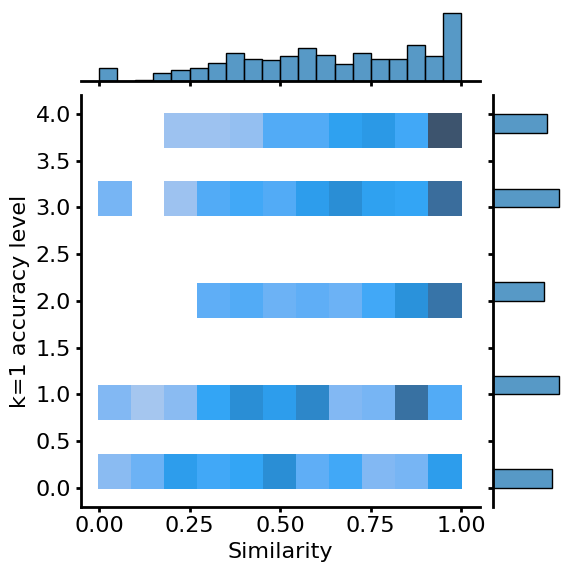

In [25]:
print(spearmanr(results['Similarity'], results['k=1 accuracy level']))
sns.jointplot(data=results, x='Similarity', y='k=1 accuracy level', kind='hist', marginal_kws=dict(bins=20, fill=True))


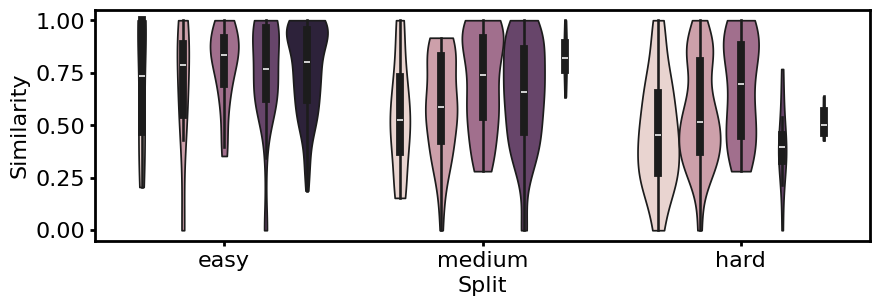

In [37]:
plt.figure(figsize=(10, 3))
sns.violinplot(data=results, x='Split', y='Similarity', hue='k=1 accuracy level', cut=False, legend=False, density_norm="count")

### Visualize some of the reactions with highest and lowest similarity

The most recent query_df should be for the hard set

In [43]:
query_df

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC,0,...,4666,4667,4668,4669,4670,4671,4672,Correct,Similarity,Split
77,N[C@@H](CCS)C(=O)O.O=c1[nH]cnc2c1ncn2[C@@H]1O[...,[NH2:1][C@@H:2]([CH2:3][CH2:4][SH:5])[C:6](=[O...,3.13.1.9,S-inosyl-L-homocysteine + H2O = inosine + L-ho...,3.13.1,3.13,3,True,1,3.5.4.28,...,1.6.3.2,1.8.1.18,2.7.8.23,5.4.99.2,5.4.2.9,3.7.1.1,3.11.1.3,False,1.0,hard
94,Nc1ncnc2c1ncn2[C@H]1CC[C@@H](COP(=O)(O)OP(=O)(...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,3.6.4.13,"2',3'-dideoxy-ATP + H2O = 2',3'-dideoxy-ADP + ...",3.6.4,3.60,3,True,1,3.6.1.6,...,2.3.1.248,2.3.1.133,2.3.1.184,2.3.2.30,2.3.1.302,2.3.1.144,2.3.1.28,False,1.0,hard
146,CNc1ccccc1C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...,[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][cH:7][c:...,5.6.2.4,2'(3')-O-(N-methylanthraniloyl)ATP + H2O = 2'(...,5.6.2,5.60,5,True,1,3.6.5.3,...,4.1.1.19,2.3.1.109,1.8.1.19,4.1.1.17,2.1.4.1,2.1.4.3,2.1.4.2,False,1.0,hard
31,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C@@H:7...,1.6.1.1,NADH + 3'-NADP+ = NAD+ + 3'-NADPH,1.6.1,1.60,1,True,1,2.7.1.23,...,2.1.1.141,1.13.12.5,3.7.1.8,3.7.1.14,3.8.1.5,3.7.1.25,3.7.1.9,False,1.0,hard
65,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)C...,[CH3:1][CH:2]([CH3:3])[CH2:4][C@H:5]([NH:6][C:...,2.7.11.13,ATP + FKLKRKGSFKKFA = ADP + FKLKRKGpSFKKFA,2.7.11,2.70,2,True,1,2.7.12.1,...,3.1.1.6,3.1.1.56,3.1.1.104,3.1.1.72,3.1.1.25,4.2.1.53,3.1.8.1,False,1.0,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,1.2.7.4,propionyl-SCoA + CoASH = propionyl-SCoA + CoAS...,1.2.7,1.20,1,True,1,2.3.1.155,...,1.17.9.1,3.2.1.24,3.2.1.11,1.1.3.5,3.2.1.57,5.5.1.20,1.1.3.42,False,0.0,hard
128,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.99.1.9,protoporphyrin IX + Cu2+ = Cu-protoporphyrin I...,4.99.1,4.99,4,True,1,1.5.99.15,...,2.7.1.6,2.4.1.13,1.14.15.35,6.3.1.1,2.3.1.109,2.3.2.30,2.4.1.245,False,0.0,hard
127,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,1,3.5.4.27,...,2.4.1.245,2.3.1.183,2.3.1.271,2.3.1.53,2.7.1.157,2.3.1.109,2.3.2.30,False,0.0,hard
78,O.O=C(O)[C@H]1O[C@H](O[C@@H]2[C@H](O)[C@@H](O)...,[O:2]=[C:3]([OH:4])[C@H:5]1[O:6][C@H:7]([O:8][...,3.2.1.15,"alpha-D-galacturonosyl-(1,4)-O-alpha-D-galactu...",3.2.1,3.20,3,True,1,3.2.1.40,...,2.7.4.26,2.7.14.1,2.7.4.16,2.7.1.39,2.1.1.5,2.7.3.3,2.1.1.258,False,0.0,hard


In [65]:
rxns = []
rxn2s = []
for index in query_df.index:
    rxn = query_df['Reaction'].values[index]
    EC_number = query_df['EC number'].values[index]
    predicted_EC_number = query_df['0'].values[index]

    reference_subset = reference_df[reference_df['EC number'] == predicted_EC_number]
    if len(reference_subset) == 1:
        rxn2 = reference_subset['Reaction'].values[0]
        
        rxns.append(rxn)
        rxn2s.append(rxn2)

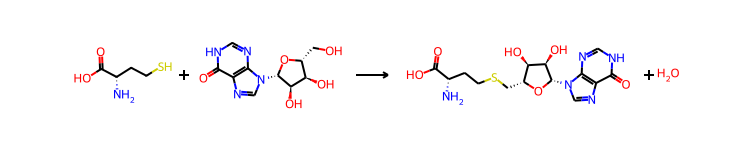

In [77]:
index=0
AllChem.ReactionFromSmarts(rxns[index], useSmiles=True)

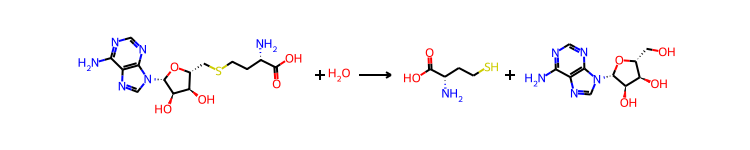

In [78]:
AllChem.ReactionFromSmarts(rxn2s[index], useSmiles=True) 